# Partition of feature space by random forest

In [146]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'

from sklearn import tree
from dtreeviz.trees import *
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree


In [153]:
wine = load_wine()
X = wine.data
X = X[:,[12,6]]
y = wine.target
len(X), len(y)

colors = {'classes':
          [None, # 0 classes
          None, # 1 class
          ["#FEFEBB","#a1dab4"], # 2 classes
          ["#FEFEBB","#D9E6F5",'#a1dab4'], # 3
          ]
         }

feature_c_bivar = ['proline','flavanoid']
target_c_bivar = "wine"
class_name_bivar = list(wine.target_names)
feature_c_bivar, target_c_bivar,  class_name_bivar

(['proline', 'flavanoid'], 'wine', ['class_0', 'class_1', 'class_2'])

## Decision tree

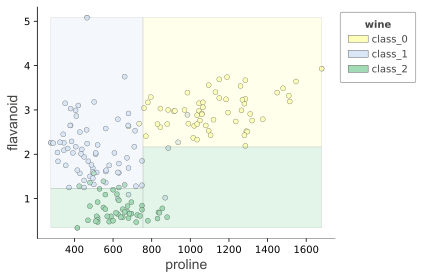

In [154]:
dtc_bivar = DecisionTreeClassifier(max_depth=2)
dtc_bivar.fit(X, y)

ctreeviz_bivar(dtc_bivar, X, y, 
               feature_names=feature_c_bivar, target_name=target_c_bivar, class_names=class_name_bivar,
               show={'splits', "legend"}, 
               colors={'scatter_edge': 'black'})
plt.tight_layout()
plt.show()

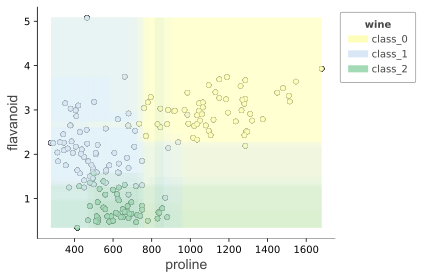

In [281]:
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=feature_c_bivar, target_name=target_c_bivar, class_names=class_name_bivar,
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.1,
                           'rect_edge':None},
                   ax=ax)
plt.tight_layout()
plt.show()

In [253]:
import tsensor

In [254]:
rf.predict_proba(X)[0:5]

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.52234271, 0.45765729, 0.02      ]])

In [255]:
from dtreeviz.colors import color_blind_friendly_colors
from PIL import ImageColor
rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in color_blind_friendly_colors[3]])
rgb # 3 x 3 rgb for each class' color

array([[254, 254, 187],
       [217, 230, 245],
       [161, 218, 180]])

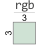

In [256]:
with tsensor.explain():
    rgb

In [257]:
# multiply each probability vector times rgb color for each class then add together to get weighted color
(rf.predict_proba(X) @ rgb)[0:10]

array([[254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [235.20668038, 242.29622511, 213.40412266],
       [254.        , 254.        , 187.        ],
       [252.97809524, 253.33714286, 188.60190476],
       [252.91642857, 253.29714286, 188.69857143],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ]])

In [258]:
from colour import Color
foo = (rf.predict_proba(X) @ rgb)[0:10] / 255 # to 0..1
[Color(rgb=x) for x in foo]

[<Color #fefebb>,
 <Color #fefebb>,
 <Color #fefebb>,
 <Color #fefebb>,
 <Color #ebf2d5>,
 <Color #fefebb>,
 <Color #fdfdbd>,
 <Color #fdfdbd>,
 <Color #fefebb>,
 <Color #fefebb>]

[[2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [1 1 2 1 2 2 2 2 2 2]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]]
[[2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [1 1 2 1 2 2 2 2 2 2]
 [1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]]


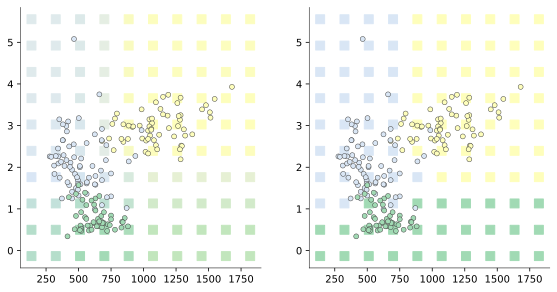

In [575]:
import colour
from dtreeviz.colors import color_blind_friendly_colors
from dtreeviz.colors import adjust_colors
from PIL import ImageColor

def viz_proba(model, X, ax, npoints=100, nshades=200, alpha=.3,
              dotsize=.5, padding=.03, show_proba=True):
    global y_pred, gridpoints # REMOVE LATER
    class_values = np.unique(y)
    nclasses = len(class_values)
    
    x1 = X[:,0]
    x2 = X[:,1]
    x1range=max(x1) - min(x1)
    x2range=max(x2) - min(x2)
    x1padding = x1range * padding
    x2padding = x2range * padding
    x1range=(min(x1)-x1padding, max(x1)+x1padding)
    x2range=(min(x2)-x2padding, max(x2)+x2padding)
    gridpoints = [] # a list of coordinate pairs for the grid
    gridcoords = [] # a list of coordinate pairs for the grid
    # Iterate through v1 most quickly then v2
    for iv2,v2 in enumerate(np.linspace(*x2range,num=npoints)):
        for iv1,v1 in enumerate(np.linspace(*x1range,num=npoints)):
            gridpoints.append([v1,v2])
    gridpoints = np.array(gridpoints)

    proba = model.predict_proba(gridpoints)
    y_pred = np.argmax(proba, axis=1)
    colors = adjust_colors(None)
    color_values = adjust_colors(None)['classes'][nclasses]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}
    
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in color_blind_friendly_colors[nclasses]])
    
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    mycolors = proba @ rgb
    mycolors /= 255 # get in [0..1]
    mycolors = [Color(rgb=c).hex for c in mycolors]
    
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    
    # Draw probabilities grid
    border = min(x1padding,x2padding) # leave some whitespace between plot and spines
    x1range=(min(x1)-x1padding-border, max(x1)+x1padding+border)
    x2range=(min(x2)-x2padding-border, max(x2)+x2padding+border)
#     ax.set_xlim(*x1range)
#     ax.set_ylim(*x2range)
    
    if show_proba:
        ax.scatter(gridpoints[:,0], gridpoints[:,1], s=dotsize, c=mycolors, alpha=alpha, marker='s')
    else:
        y_pred_color = np.array(color_blind_friendly_colors[nclasses])[y_pred]
#         print(np.flip(y_pred.reshape(npoints,npoints), axis=0))
#         print(y_pred.reshape(npoints,npoints))
#         print(np.flip(gridpoints.reshape(npoints,npoints), axis=0))
        ax.scatter(gridpoints[:,0], gridpoints[:,1], s=dotsize, c=y_pred_color, alpha=alpha, marker='s')
    
    # Draw boundary locations
    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    y_pred = y_pred.reshape(npoints,npoints)
    print(y_pred)

    """
    toptwo = np.sort(proba, axis=1)[:,-2:]
#     print(toptwo[np.isclose(toptwo[:,0], toptwo[:,1], atol=.01)])
    similar_prediction_indexes = np.where(np.isclose(toptwo[:,0], toptwo[:,1], atol=.05))[0]
#     print(similar_prediction_indexes)
    similar_prediction_gridpoints = gridpoints[similar_prediction_indexes]
#     print(similar_prediction_gridpoints)
    ax.scatter(similar_prediction_gridpoints[:,0], similar_prediction_gridpoints[:,1],
               s=dotsize, c='k', alpha=1.0, marker='s')
    """
    
    # Draw the instances
    dot_w = 25
    X_hist = [X[y == cl] for cl in class_values]
    for i, h in enumerate(X_hist):
        ax.scatter(h[:, 0], h[:, 1], marker='o', s=dot_w, c=color_map[i],
                   edgecolors=colors['scatter_edge'], lw=.5)


rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

fig,axes = plt.subplots(1,2, figsize=(9.5,4.8))
viz_proba(rf, X, npoints=10, ax=axes[0], alpha=1.0, dotsize=80, padding=0.1, show_proba=True)
viz_proba(rf, X, npoints=10, ax=axes[1], alpha=1.0, dotsize=80, padding=0.1, show_proba=False)
plt.show()

In [565]:
#gridpoints.reshape(npoints,npoints,2)

In [585]:
y_pred

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 2, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [586]:
np.diff(y_pred, axis=0)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  0, -1, -2, -2, -2, -2, -2],
       [ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [578]:
ix,iy = np.where(np.diff(y_pred, axis=0))
ix,iy

(array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3]),
 array([0, 1, 3, 2, 4, 5, 6, 7, 8, 9, 4]))

In [579]:
foo = gridpoints.reshape(npoints,npoints,2)
#foo[ix,iy]

In [580]:
np.diff(y_pred, axis=1)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, -1,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0]])

In [581]:
ix,iy = np.where(np.diff(y_pred, axis=1))
ix,iy

(array([2, 2, 2, 3, 4, 5, 6, 7, 8, 9]), array([1, 2, 3, 4, 3, 3, 3, 3, 3, 3]))

In [582]:
np.vstack([np.zeros(npoints).reshape(1,-1), np.diff(y_pred, axis=0)])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  0., -1., -2., -2., -2., -2., -2.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [583]:
np.hstack([np.zeros(npoints).reshape(-1,1), np.diff(y_pred, axis=1)])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.]])

In [591]:
#np.flip(
np.abs(np.vstack([np.zeros(npoints).reshape(1,-1), np.diff(y_pred, axis=0)])) + \
np.abs(np.hstack([np.zeros(npoints).reshape(-1,1), np.diff(y_pred, axis=1)]))
#    , axis=0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 2., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 3., 2., 2., 2., 2.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [593]:
rows,cols = np.where(
    np.abs(np.vstack([np.zeros(npoints).reshape(1,-1), np.diff(y_pred, axis=0)])) + \
    np.abs(np.hstack([np.zeros(npoints).reshape(-1,1), np.diff(y_pred, axis=1)]))
)
rows,cols

(array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 2, 4, 5, 6, 7, 8, 9, 4, 4, 4, 4, 4, 4]))

In [517]:
npoints=5
nclasses=3
x1 = X[:,0]
x2 = X[:,1]
x1range=max(x1) - min(x1)
x2range=max(x2) - min(x2)
x1padding = 0
x2padding = 0
x1range=(min(x1)-x1padding, max(x1)+x1padding)
x2range=(min(x2)-x2padding, max(x2)+x2padding)
gridpoints = [] # a list of coordinate pairs for the grid
gridcoords = [] # a list of coordinate pairs for the grid
grid = np.zeros(shape=(npoints,npoints,nclasses))
for iv1,v1 in enumerate(np.linspace(*x1range,num=npoints)):
    for iv2,v2 in enumerate(np.linspace(*x2range,num=npoints)):
        gridpoints.append([v1,v2])
        foo = np.array([v1,v2]).reshape(1,-1)
        grid[iv1,iv2] = model.predict_proba(foo)[0]
gridpoints = np.array(gridpoints)
#gridpoints.reshape(npoints,npoints,2)

In [524]:
mx, my = np.meshgrid(np.linspace(*x1range,num=npoints), np.linspace(*x2range,num=npoints))
mx, my

(array([[ 278. ,  628.5,  979. , 1329.5, 1680. ],
        [ 278. ,  628.5,  979. , 1329.5, 1680. ],
        [ 278. ,  628.5,  979. , 1329.5, 1680. ],
        [ 278. ,  628.5,  979. , 1329.5, 1680. ],
        [ 278. ,  628.5,  979. , 1329.5, 1680. ]]),
 array([[0.34 , 0.34 , 0.34 , 0.34 , 0.34 ],
        [1.525, 1.525, 1.525, 1.525, 1.525],
        [2.71 , 2.71 , 2.71 , 2.71 , 2.71 ],
        [3.895, 3.895, 3.895, 3.895, 3.895],
        [5.08 , 5.08 , 5.08 , 5.08 , 5.08 ]]))

In [525]:
mx*my

array([[  94.52  ,  213.69  ,  332.86  ,  452.03  ,  571.2   ],
       [ 423.95  ,  958.4625, 1492.975 , 2027.4875, 2562.    ],
       [ 753.38  , 1703.235 , 2653.09  , 3602.945 , 4552.8   ],
       [1082.81  , 2448.0075, 3813.205 , 5178.4025, 6543.6   ],
       [1412.24  , 3192.78  , 4973.32  , 6753.86  , 8534.4   ]])

## Titantic

In [85]:
df = pd.read_csv("../data/titanic/titanic.csv")
df['Sex'] = np.where(df['Sex']=='male', 0, 1)
df.head().T

0  \
PassengerId                        1   
Survived                           0   
Pclass                             3   
Name         Braund, Mr. Owen Harris   
Sex                                0   
Age                               22   
SibSp                              1   
Parch                              0   
Ticket                     A/5 21171   
Fare                            7.25   
Cabin                            NaN   
Embarked                           S   

                                                             1  \
PassengerId                                                  2   
Survived                                                     1   
Pclass                                                       1   
Name         Cumings, Mrs. John Bradley (Florence Briggs Th...   
Sex                                                          1   
Age                                                         38   
SibSp                                                        1   
Parch                                                        0   
Ticket                                                PC 17599   
Fare                                                   71.2833   
Cabin                                                      C85   
Embarked                                                     C   

                                  2  \
PassengerId                       3   
Survived                          1   
Pclass                            3   
Name         Heikkinen, Miss. Laina   
Sex                               1   
Age                              26   
SibSp                             0   
Parch                             0   
Ticket             STON/O2. 3101282   
Fare                          7.925   
Cabin                           NaN   
Embarked                          S   

                                                        3  \
PassengerId                                             4   
Survived                                                1   
Pclass                                                  1   
Name         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
Sex                                                     1   
Age                                                    35   
SibSp                                                   1   
Parch                                                   0   
Ticket                                             113803   
Fare                                                 53.1   
Cabin                                                C123   
Embarked                                                S   

                                    4  
PassengerId                         5  
Survived                            0  
Pclass                              3  
Name         Allen, Mr. William Henry  
Sex                                 0  
Age                                35  
SibSp                               0  
Parch                               0  
Ticket                         373450  
Fare                             8.05  
Cabin                             NaN  
Embarked                            S

In [86]:
X, y = df.drop(['Survived','Name','Ticket','Cabin','Embarked'], axis=1), df['Survived']
X['Age_na'] = X['Age'].isna()
X['Age'] = X['Age'].fillna(X['Age'].median(skipna=True))
X.T

0        1      2      3      4       5        6       7    \
PassengerId      1        2      3      4      5       6        7       8   
Pclass           3        1      3      1      3       3        1       3   
Sex              0        1      1      1      0       0        0       0   
Age             22       38     26     35     35      28       54       2   
SibSp            1        1      0      1      0       0        0       3   
Parch            0        0      0      0      0       0        0       1   
Fare          7.25  71.2833  7.925   53.1   8.05  8.4583  51.8625  21.075   
Age_na       False    False  False  False  False    True    False   False   

                 8        9    ...     881      882    883    884     885  \
PassengerId        9       10  ...     882      883    884    885     886   
Pclass             3        2  ...       3        3      2      3       3   
Sex                1        1  ...       0        1      0      0       1   
Age               27       14  ...      33       22     28     25      39   
SibSp              0        1  ...       0        0      0      0       0   
Parch              2        0  ...       0        0      0      0       5   
Fare         11.1333  30.0708  ...  7.8958  10.5167   10.5   7.05  29.125   
Age_na         False    False  ...   False    False  False  False   False   

               886    887    888    889    890  
PassengerId    887    888    889    890    891  
Pclass           2      1      3      1      3  
Sex              0      1      1      0      0  
Age             27     19     28     26     32  
SibSp            0      0      1      0      0  
Parch            0      0      2      0      0  
Fare            13     30  23.45     30   7.75  
Age_na       False  False   True  False  False  

[8 rows x 891 columns]

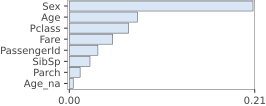

In [87]:
from rfpimp import *

rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

I = importances(rf, X, y)
plot_importances(I)

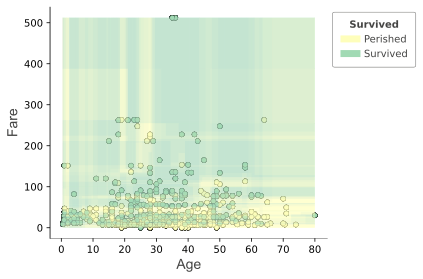

In [90]:
# Pick Sex, Pclass
X = X[['Age','Fare']]
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=['Age','Fare'], target_name="Survived",
                   class_names=['Perished','Survived'],
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.1,
                          'rect_edge':None},
                   ax=ax)
plt.tight_layout()
plt.show()

## cancer

In [128]:
cancer = load_breast_cancer()

df = pd.DataFrame(data=cancer.data)
df.columns = [f'f{i}' for i in range(df.shape[1])]
df['y'] = cancer.target
df.head(3)

f0     f1     f2      f3       f4       f5      f6       f7      f8  \
0  17.99  10.38  122.8  1001.0  0.11840  0.27760  0.3001  0.14710  0.2419   
1  20.57  17.77  132.9  1326.0  0.08474  0.07864  0.0869  0.07017  0.1812   
2  19.69  21.25  130.0  1203.0  0.10960  0.15990  0.1974  0.12790  0.2069   

        f9  ...    f21    f22     f23     f24     f25     f26     f27     f28  \
0  0.07871  ...  17.33  184.6  2019.0  0.1622  0.6656  0.7119  0.2654  0.4601   
1  0.05667  ...  23.41  158.8  1956.0  0.1238  0.1866  0.2416  0.1860  0.2750   
2  0.05999  ...  25.53  152.5  1709.0  0.1444  0.4245  0.4504  0.2430  0.3613   

       f29  y  
0  0.11890  0  
1  0.08902  0  
2  0.08758  0  

[3 rows x 31 columns]

In [129]:
X, y = df.drop('y',axis=1), y

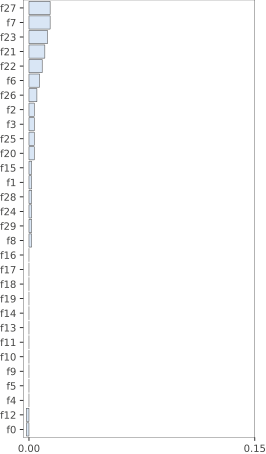

In [130]:
rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

I = importances(rf, X, y)
plot_importances(I)

In [ ]:
# pick f27 and f7

In [140]:
X = df[['f27','f7']]

rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=['f27','f7'], target_name="cancer",
                   class_names=['not-cancer','cancer'],
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.05},
                   ax=ax)
plt.tight_layout()
plt.show()

In [143]:
rf.predict_proba(X)[0:20]

array([[1.        , 0.        ],
       [0.90972222, 0.09027778],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.9702381 , 0.0297619 ],
       [0.97916667, 0.02083333],
       [0.9625    , 0.0375    ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.18880952, 0.81119048],
       [0.96547619, 0.03452381],
       [1.        , 0.        ],
       [0.64033069, 0.35966931],
       [1.        , 0.        ],
       [0.89781746, 0.10218254],
       [0.88369048, 0.11630952],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.14777778, 0.85222222]])